In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# dlib라이브러리를 이용한 사람 얼굴 찾기 + 눈 위치를 기준으로 수평 맞추기(Alignment)

In [2]:
!pip install facenet-pytorch

In [4]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from facenet_pytorch import MTCNN
from skimage import transform as trans # 상대방 코드에서 쓴 변환 도구

# ==========================================
# 1. 설정 (경로 확인 필수!)
# ==========================================
TEST_DIR = '/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/dataset/Hecto/test_data'
MODEL_PATH = '/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/models/deepfake_model_epoch_4.pth'
SUBMISSION_PATH = '/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/Convnextv2_base_4_submission_final.csv'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 224
FRAMES_PER_VIDEO = 10 # 영상당 10장 분석

print(f"🚀 [최종] 얼굴 정렬(Alignment) 추론 시스템을 가동합니다.")

# ==========================================
# 2. 얼굴 정렬 함수 (상대방 코드 로직 이식)
# ==========================================
def align_face(img_rgb, landmarks, outsize=(224, 224)):
    """
    MTCNN이 찾은 눈,코,입 좌표(landmarks)를 기준으로
    얼굴을 수평으로 맞추고(Align) 잘라냅니다(Crop).
    """
    # 상대방 코드에 있는 표준 얼굴 좌표 (Reference Points)
    src = np.array([
        [30.2946, 51.6963], # 왼쪽 눈
        [65.5318, 51.5014], # 오른쪽 눈
        [48.0252, 71.7366], # 코
        [33.5493, 92.3655], # 왼쪽 입꼬리
        [62.7299, 92.2041]  # 오른쪽 입꼬리
    ], dtype=np.float32)

    # 112x112 기준 좌표를 우리가 원하는 224x224 크기에 맞게 스케일링
    src[:, 0] *= (outsize[0] / 112.0)
    src[:, 1] *= (outsize[1] / 112.0)

    # MTCNN 랜드마크 (5개 점)
    dst = landmarks.astype(np.float32)

    # 변환 행렬 계산 (얼굴을 표준 좌표에 맞추기 위해 어떻게 회전/이동해야 하는지 계산)
    tform = trans.SimilarityTransform()
    tform.estimate(dst, src) # dst(내 얼굴) -> src(표준 얼굴)로 가는 변환
    M = tform.params[0:2, :]

    # 이미지 변환 (Warp)
    aligned = cv2.warpAffine(img_rgb, M, (outsize[1], outsize[0]), borderValue=0.0)
    return aligned

# ==========================================
# 3. 모델 정의
# ==========================================
class DeepfakeDetector(nn.Module):
    def __init__(self, model_name='convnextv2_base.fcmae_ft_in22k_in1k', pretrained=False):
        super(DeepfakeDetector, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        if hasattr(self.backbone, 'head') and hasattr(self.backbone.head, 'fc'):
            n_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        else:
            n_features = self.backbone.num_features
            self.backbone.reset_classifier(0)

        self.classifier = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# ==========================================
# 4. 데이터셋 (MTCNN + Alignment 적용)
# ==========================================
class AdvancedInferenceDataset(Dataset):
    def __init__(self, video_dir, frames_per_video=10):
        self.video_dir = video_dir
        self.video_files = sorted([f for f in os.listdir(video_dir) if f.endswith('.mp4')])
        self.frames_per_video = frames_per_video

        # MTCNN 설정 (얼굴 탐지기)
        # keep_all=False: 제일 큰 얼굴 하나만 잡음
        self.mtcnn = MTCNN(keep_all=False, select_largest=True, device=device, post_process=False)

        # 모델 입력용 변환
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # 비상용 (얼굴 못 찾았을 때)
        self.fallback = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_name = self.video_files[idx]
        video_path = os.path.join(self.video_dir, video_name)

        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0:
            return video_name, torch.zeros((self.frames_per_video, 3, IMG_SIZE, IMG_SIZE))

        indices = np.linspace(0, total_frames - 1, self.frames_per_video, dtype=int)
        frames = []

        for i in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if not ret:
                frames.append(torch.zeros((3, IMG_SIZE, IMG_SIZE)))
                continue

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_pil = Image.fromarray(frame_rgb)

            # 1. MTCNN으로 얼굴 박스랑 랜드마크(눈,코,입) 찾기
            boxes, probs, landmarks = self.mtcnn.detect(frame_pil, landmarks=True)

            if boxes is not None:
                # 2. 얼굴 정렬 (Alignment) - 여기가 핵심!
                # landmarks[0]은 (5, 2) 모양의 좌표 (눈, 코, 입)
                aligned_face_np = align_face(frame_rgb, landmarks[0], outsize=(IMG_SIZE, IMG_SIZE))

                # 3. 텐서 변환
                face_tensor = self.transform(aligned_face_np)
                frames.append(face_tensor)
            else:
                # 얼굴 없으면 중앙 자르기
                frames.append(self.fallback(frame_pil))

        cap.release()

        # 부족분 채우기
        while len(frames) < self.frames_per_video:
            frames.append(torch.zeros((3, IMG_SIZE, IMG_SIZE)))

        return video_name, torch.stack(frames)

# ==========================================
# 5. 실행
# ==========================================
# ⚠️ 중요: MTCNN 사용 시 num_workers=0 이어야 안전합니다.
print("⏳ 데이터셋 준비 중... (얼굴 정렬에는 시간이 좀 걸립니다)")
test_dataset = AdvancedInferenceDataset(TEST_DIR, frames_per_video=FRAMES_PER_VIDEO)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"🤖 모델 로드: {os.path.basename(MODEL_PATH)}")
model = DeepfakeDetector().to(device)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    print("❌ 모델 파일 없음")
    exit()
model.eval()

results = []
print(f"🚀 분석 시작! (Align + Crop 적용됨)")

with torch.no_grad():
    for video_name, frames in tqdm(test_loader):
        frames = frames.squeeze(0).to(device)

        outputs = model(frames)
        probs = torch.sigmoid(outputs).cpu().numpy()

        # Fake(0) vs Real(1)
        # 사용자 모델은 Fake=0, Real=1 이므로
        # Fake일 확률을 구하려면 (1 - Real확률)을 해야 합니다.
        # 만약 모델 출력이 'Real일 확률'이라면:
        # fake_prob = 1.0 - probs

        # ⚠️ [중요 체크]
        # 사용자님의 class map: {'Fake': 0, 'Real': 1}
        # 모델 출력값(Sigmoid)은 1(Real)에 가까울 확률입니다.
        # 하지만 대회는 보통 "Fake일 확률"을 내라고 합니다.
        # 따라서 뒤집어줘야 합니다.
        fake_probs = 1.0 - probs

        avg_fake_prob = np.mean(fake_probs)

        # ID 추출 (TEST_000.mp4 -> TEST_000)
        video_id = video_name[0].split('.')[0]

        results.append({
            'id': video_id,
            'label': avg_fake_prob
        })

# 저장
df = pd.DataFrame(results)
df.to_csv(SUBMISSION_PATH, index=False)
print(f"\n🎉 완료! 저장됨: {SUBMISSION_PATH}")
print(df.head())

🚀 [최종] 얼굴 정렬(Alignment) 추론 시스템을 가동합니다.
⏳ 데이터셋 준비 중... (얼굴 정렬에는 시간이 좀 걸립니다)
🤖 모델 로드: deepfake_model_epoch_4.pth
🚀 분석 시작! (Align + Crop 적용됨)


100%|██████████| 223/223 [10:39<00:00,  2.87s/it]


🎉 완료! 저장됨: /content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/Convnextv2_base_4_submission_final.csv
         id     label
0  TEST_000  0.454006
1  TEST_002  0.109844
2  TEST_003  0.007174
3  TEST_005  0.614152
4  TEST_006  0.381249


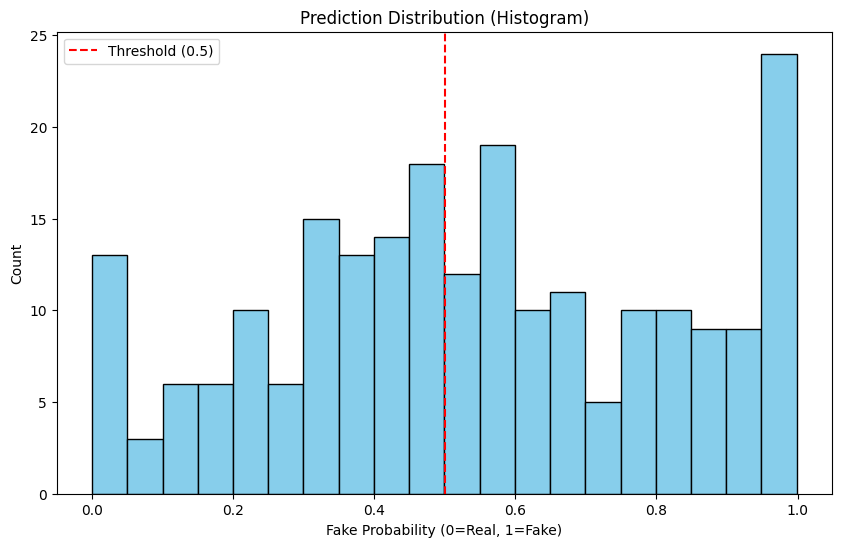

count    223.000000
mean       0.540259
std        0.281396
min        0.000544
25%        0.337806
50%        0.519926
75%        0.776542
max        0.998809
Name: label, dtype: float64


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 방금 만든 csv 파일 읽기
df = pd.read_csv('/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/Convnextv2_base_4_submission_final.csv')

# 확률 분포 그리기
plt.figure(figsize=(10, 6))
plt.hist(df['label'], bins=20, color='skyblue', edgecolor='black')
plt.title('Prediction Distribution (Histogram)')
plt.xlabel('Fake Probability (0=Real, 1=Fake)')
plt.ylabel('Count')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.legend()
plt.show()

# 통계치 확인
print(df['label'].describe())

In [7]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from facenet_pytorch import MTCNN
from skimage import transform as trans

# ==========================================
# 1. Settings (Check Paths!)
# ==========================================
TEST_DIR = '/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/dataset/Hecto/test_data'
SAMPLE_SUB_PATH = '/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/sample_submission.csv'
MODEL_PATH = '/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/models/deepfake_model_epoch_4.pth'
FINAL_SUB_PATH = '/content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/Convnextv2_base_4_submission_final_inverted.csv'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 224
FRAMES_PER_VIDEO = 10

print(f"🚀 [Logic Inverted] Generating submission where Model Output = Fake Probability.")

# ==========================================
# 2. Model Definition
# ==========================================
class DeepfakeDetector(nn.Module):
    def __init__(self, model_name='convnextv2_base.fcmae_ft_in22k_in1k', pretrained=False):
        super(DeepfakeDetector, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        if hasattr(self.backbone, 'head') and hasattr(self.backbone.head, 'fc'):
            n_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
        else:
            n_features = self.backbone.num_features
            self.backbone.reset_classifier(0)
        self.classifier = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Face Alignment Function
def align_face(img_rgb, landmarks, outsize=(224, 224)):
    src = np.array([
        [30.2946, 51.6963], [65.5318, 51.5014], [48.0252, 71.7366],
        [33.5493, 92.3655], [62.7299, 92.2041]
    ], dtype=np.float32)
    src[:, 0] *= (outsize[0] / 112.0)
    src[:, 1] *= (outsize[1] / 112.0)
    dst = landmarks.astype(np.float32)
    tform = trans.SimilarityTransform()
    tform.estimate(dst, src)
    M = tform.params[0:2, :]
    return cv2.warpAffine(img_rgb, M, (outsize[1], outsize[0]), borderValue=0.0)

# ==========================================
# 3. Dataset (Image + Video)
# ==========================================
class UnifiedInferenceDataset(Dataset):
    def __init__(self, file_list, root_dir, frames_per_video=10):
        self.file_list = file_list
        self.root_dir = root_dir
        self.frames_per_video = frames_per_video
        self.mtcnn = MTCNN(keep_all=False, select_largest=True, device=device, post_process=False)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.fallback = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(IMG_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.file_list)

    def process_frame(self, frame_pil):
        try:
            boxes, probs, landmarks = self.mtcnn.detect(frame_pil, landmarks=True)
            if boxes is not None:
                frame_np = np.array(frame_pil)
                aligned_face = align_face(frame_np, landmarks[0], outsize=(IMG_SIZE, IMG_SIZE))
                return self.transform(aligned_face)
        except:
            pass
        return self.fallback(frame_pil)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        file_path = os.path.join(self.root_dir, filename)
        frames = []

        # 1. Check if file exists
        if not os.path.exists(file_path):
            return filename, torch.zeros((self.frames_per_video, 3, IMG_SIZE, IMG_SIZE))

        # 2. Image Processing
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif', '.bmp')):
            try:
                img = Image.open(file_path).convert('RGB')
                frame_tensor = self.process_frame(img)
                frames = [frame_tensor] * self.frames_per_video
            except:
                frames = [torch.zeros((3, IMG_SIZE, IMG_SIZE))] * self.frames_per_video

        # 3. Video Processing
        else:
            cap = cv2.VideoCapture(file_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames > 0:
                indices = np.linspace(0, total_frames - 1, self.frames_per_video, dtype=int)
                for i in indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                    ret, frame = cap.read()
                    if ret:
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frames.append(self.process_frame(Image.fromarray(frame_rgb)))
                    else:
                        frames.append(torch.zeros((3, IMG_SIZE, IMG_SIZE)))
            cap.release()
            while len(frames) < self.frames_per_video:
                frames.append(torch.zeros((3, IMG_SIZE, IMG_SIZE)))

        return filename, torch.stack(frames)

# ==========================================
# 4. Execution & Saving
# ==========================================
if not os.path.exists(SAMPLE_SUB_PATH):
    print(f"❌ Error: Sample file not found ({SAMPLE_SUB_PATH})")
    exit()

sample_df = pd.read_csv(SAMPLE_SUB_PATH)
target_files = sample_df['filename'].tolist()

print(f"📂 Loaded sample files: {len(target_files)}")

test_dataset = UnifiedInferenceDataset(target_files, TEST_DIR, frames_per_video=FRAMES_PER_VIDEO)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"🤖 Loading Model: {os.path.basename(MODEL_PATH)}")
model = DeepfakeDetector().to(device)
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH))
else:
    print("❌ Model file not found")
    exit()
model.eval()

results = {}
print(f"🚀 Analysis Start! (Logic Inverted)")

with torch.no_grad():
    for filename, frames in tqdm(test_loader):
        filename = filename[0]
        frames = frames.squeeze(0).to(device)

        if frames.sum() == 0:
            results[filename] = 0.5
            continue

        outputs = model(frames)
        probs = torch.sigmoid(outputs).cpu().numpy()

        # 🔥 [CHANGED] Removed '1.0 - probs'
        # We assume the model outputs the probability of being 'Fake' directly.
        # Or if it outputs 'Real', we are intentionally flipping the submission logic compared to last time.
        fake_probs = probs

        avg_fake_prob = np.mean(fake_probs)
        results[filename] = avg_fake_prob

# 5. Save
sample_df['prob'] = sample_df['filename'].map(results).fillna(0.5)
sample_df.to_csv(FINAL_SUB_PATH, index=False)

print(f"\n🎉 Submission Generated: {FINAL_SUB_PATH}")
print(sample_df.tail())

🚀 [Logic Inverted] Generating submission where Model Output = Fake Probability.
📂 Loaded sample files: 500
🤖 Loading Model: deepfake_model_epoch_4.pth
🚀 Analysis Start! (Logic Inverted)


100%|██████████| 500/500 [10:07<00:00,  1.22s/it]


🎉 Submission Generated: /content/drive/MyDrive/DILAB/OK/hecto-deepfake-detection/Convnextv2_base_4_submission_final_inverted.csv
          filename      prob
495   TEST_495.jpg  0.379034
496   TEST_496.jpg  0.003146
497   TEST_497.mp4  0.311179
498   TEST_498.mp4  0.106462
499  TEST_499.jfif  0.951526
